# 02.20.02 - DNN MFCC20 (60-10-30) SOFTMAX

## Goals

In this experiment, we get a first idea about the performance of a Dense Neural Network using MFCC coefficients as features, through a simple train/valid/test random split of the dataset.


## Prerequisites

- The dataset exists (if not, execute 02.00)
- The dataset features have been populated (if not, execute 02.01)


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information
    predestination,                  # Seeds the various PRNGs for reproducibility 
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification

VALID_FRAC = 0.1
TEST_FRAC  = 0.3


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
ds.queryDataFrame(sql)

[2020-09-04/16:45:03.915|38.7%|88.5%|0.28GB] ------------------------------------------------------
[2020-09-04/16:45:03.916|00.0%|88.5%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-04/16:45:03.916|00.0%|88.5%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-04/16:45:03.916|00.0%|88.5%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-04/16:45:03.916|00.0%|88.5%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-04/16:45:03.917|00.0%|88.5%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-04/16:45:03.917|00.0%|88.5%|0.28GB] SAMPLE RATE           : 22050
[2020-09-04/16:45:03.917|00.0%|88.5%|0.28GB] DURATION              : 1.0
[2020-09-04/16:45:03.917|00.0%|88.5%|0.28GB] OVERLAP               : 0.0
[2020-09-04/16:45:03.918|00.0%|88.5%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-04/16:45:03.918|00.0%|88.5%|0.28GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning 

In [2]:
from tensorflow import keras

def nn(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(2, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", optimizer="nadam",
        metrics=[
            "accuracy",
            "categorical_crossentropy"
        ]
    )    
    
    return model

In [3]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from audace.splitters import splitTrainValidTest


# Seed the various PRNGs
predestination()

# Build training and test datasets
iprint(">>>>> Building partitions training/validation/test")
X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTest(
    df,
    VALID_FRAC,
    TEST_FRAC,
    FEATURE_NAME,
    LABEL_NAME
)

# Standardize data 
iprint(">>>>> Standardize")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# One Hot encode scalar label
iprint(">>>>>> Encode")
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train)
y_valid = ohe.transform(y_valid)
y_test = ohe.transform(y_test)

# Build NN
iprint(">>>>> Build NN")
keras.backend.clear_session()
model = nn(X_train[0].shape)

iprint(F">>>>> Train on {len(X_train)}, validate on {len(X_valid)}, test on {len(X_test)}")

early_stopping_cb = keras.callbacks.EarlyStopping(
                        monitor='val_categorical_crossentropy',
                        patience=10,
                        restore_best_weights=True
                    )

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb],
                    verbose=2
          )

[2020-09-04/16:45:04.586|41.0%|90.4%|0.35GB] >>>>> Building partitions training/validation/test
[2020-09-04/16:45:04.706|35.9%|91.1%|0.41GB] >>>>> Standardize
[2020-09-04/16:45:05.012|39.9%|91.2%|0.41GB] >>>>>> Encode
[2020-09-04/16:45:05.015|37.5%|91.2%|0.41GB] >>>>> Build NN
[2020-09-04/16:45:05.118|35.4%|91.2%|0.41GB] >>>>> Train on 10322, validate on 1721, test on 5162
Train on 10322 samples, validate on 1721 samples
Epoch 1/100
10322/10322 - 1s - loss: 0.1533 - accuracy: 0.9435 - categorical_crossentropy: 0.1533 - val_loss: 0.0585 - val_accuracy: 0.9837 - val_categorical_crossentropy: 0.0585
Epoch 2/100
10322/10322 - 0s - loss: 0.0458 - accuracy: 0.9868 - categorical_crossentropy: 0.0458 - val_loss: 0.0469 - val_accuracy: 0.9849 - val_categorical_crossentropy: 0.0469
Epoch 3/100
10322/10322 - 0s - loss: 0.0289 - accuracy: 0.9923 - categorical_crossentropy: 0.0289 - val_loss: 0.0390 - val_accuracy: 0.9878 - val_categorical_crossentropy: 0.0390
Epoch 4/100
10322/10322 - 0s - loss: 0

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report


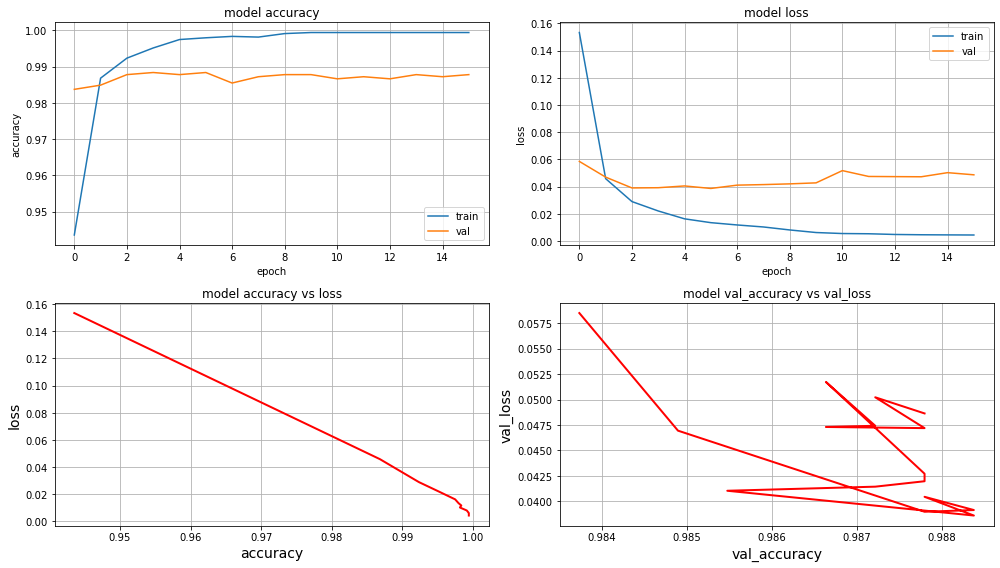

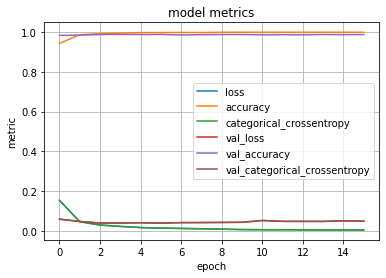

In [4]:
from audace.plotters import plot_nn_learning_curves, plot_nn_metrics

plot_nn_learning_curves(history, EXP_NAME, 'learning report')

plot_nn_metrics(history)

<hr style="border:1px solid gray"></hr>

### Step 4: Display performance report


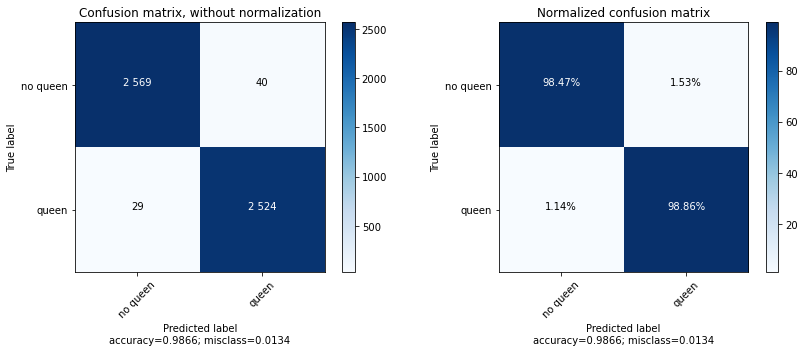

[2020-09-04/16:45:52.567|11.2%|92.6%|0.48GB] >>>>> Predict
[2020-09-04/16:45:52.821|20.3%|92.5%|0.48GB] loss: 0.04464740582788886
[2020-09-04/16:45:52.822|00.0%|92.5%|0.48GB] accuracy: 0.9866330623626709
[2020-09-04/16:45:52.822|00.0%|92.5%|0.48GB] categorical_crossentropy: 0.04464741051197052
[2020-09-04/16:45:52.978|17.5%|92.5%|0.48GB] ans: 0.90488 / acc: 0.99743


In [8]:
from audace.metrics import i_may_be_wrong_categorical
from audace.plotters import nn_full_report

nn_full_report(model, X_test, y_test, ['no queen', 'queen'], EXP_NAME, 'confusion matrix')

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = model.predict(X_test)

scores = model.evaluate(X_test, y_test, verbose=0)

for i in range(len(scores)):
    iprint(F"{model.metrics_names[i]}: {scores[i]}")
    
ans, acc = i_may_be_wrong_categorical(model, X_test, y_test, 0.99)
iprint(F"ans: {round(ans,5)} / acc: {round(acc,5)}")  